Notebook for developing functions in analyze.py

In [4]:
# figures.py imports
from __future__ import division

#from cStringIO import StringIO
import datetime
import glob
import os

import arrow
from dateutil import tz
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
from scipy import interpolate as interp

from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)

#from salishsea_tools.nowcast import figures
#from salishsea_tools.nowcast import analyze
#from salishsea_tools.nowcast import residuals

%matplotlib inline

In [5]:
t_orig=datetime.datetime(2015, 1, 22); t_final=datetime.datetime(2015, 1, 29)

In [6]:
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

# Constants

In [4]:
paths = {'nowcast': '/data/dlatorne/MEOPAR/SalishSea/nowcast/',
         'forecast': '/ocean/sallen/allen/research/MEOPAR/SalishSea/forecast/',
         'forecast2': '/ocean/sallen/allen/research/MEOPAR/SalishSea/forecast2/'}

In [5]:
colours = {'nowcast': 'DodgerBlue',
           'forecast': 'ForestGreen',
           'forecast2': 'MediumVioletRed',
           'observed': 'Indigo',
           'predicted': 'ForestGreen',
           'model': 'blue',
           'residual': 'DimGray'}

# Functions in module

In [6]:
def create_path(mode, t_orig, file_part):
    """ Creates a path to a file associated with a simulation for date t_orig. 
    E.g. create_path('nowcast',datatime.datetime(2015,1,1), 'SalishSea_1h*grid_T.nc') gives
    /data/dlatorne/MEOPAR/SalishSea/nowcast/01jan15/SalishSea_1h_20150101_20150101_grid_T.nc

    :arg mode: Mode of results - nowcast, forecast, forecast2.
    :type mode: string

    :arg t_orig: The simulation start date.
    :type t_orig: datetime object


    :arg file_part: Identifier for type of file. E.g. SalishSea_1h*grif_T.nc or ssh*.txt
    :type grid: string

    :returns: filename, run_date 
    filename is the full path of the file or an empty list if the file does not exist.
    run_date is a datetime object that represents the date the simulation ran
    """

    run_date = t_orig

    if mode == 'nowcast':
        results_home = paths['nowcast']
    elif mode == 'forecast':
        results_home = paths['forecast']
        run_date = run_date + datetime.timedelta(days=-1)
    elif mode == 'forecast2':
        results_home = paths['forecast2']
        run_date = run_date + datetime.timedelta(days=-2)

    results_dir = os.path.join(results_home,
                               run_date.strftime('%d%b%y').lower())
    
    filename = glob.glob(os.path.join(results_dir, file_part))
    
    try: 
        filename = filename[-1]
    except IndexError:
        pass

    return filename, run_date

In [7]:
create_path('forecast2', t_orig, 'SalishSea*.nc')

('/ocean/sallen/allen/research/MEOPAR/SalishSea/forecast2/20jan15/SalishSea_1h_20150122_20150123_grid_W.nc',
 datetime.datetime(2015, 1, 20, 0, 0))

In [8]:
def verified_runs(t_orig):
    """ Compiles a list of run types (nowcast, forecast, and/or forecast 2)
    that have been verified as complete by checking if their corresponding
    .nc files for that day (generated by create_path) exist.

    :arg t_orig: 
    :type t_orig: datetime object

    :returns: runs_list, list strings representing the runs that completed 
    """

    runs_list = []
    for mode in ['nowcast', 'forecast', 'forecast2']:
        files, run_date = create_path(mode, t_orig, 'SalishSea*grid_T.nc')
        if files:
            runs_list.append(mode)

    return runs_list

In [9]:
def truncate_data(data,time, sdt, edt):
    """ Truncates data for a desired time range: sdt <= time <= edt
    data and time must be numpy arrays. 
    sdt, edt, and times in time must all have a timezone or all be naive.
    
    :arg data: the data to be truncated
    :type data: numpy array
    
    :arg time: array of times associated with data
    :type time: numpy array
    
    :arg sdt: the start time of the tuncation
    :type sdt: datetime object
    
    :arg edt: the end time of the truncation
    :type edt: datetime object
    
    :returns: data_trun, time_trun, the truncated data and time arrays
    """

    inds = np.where(np.logical_and(time <=edt, time >=sdt))
    
    return data[inds], time[inds]

In [10]:
def calculate_residual(ssh, time_ssh, tides, time_tides):
    """ Calculates the residual of the model sea surface height or
    observed water levels with respect to the predicted tides.
    
    :arg ssh: Sea surface height (observed or modelled).
    :type ssh: numpy array
    
    :arg time_ssh: Time component for sea surface height (observed or modelled)
    :type time_ssh: numpy array
    
    :arg tides: Predicted tides.
    :type tides: dataFrame object
    
    :arg time_tides: Time component for predicted tides.
    :type time_tides: dataFrame object
    
    :returns: res, the residual
    """
    
    tides_interp = figures.interp_to_model_time(time_ssh, tides, time_tides)
    res = ssh - tides_interp
    
    return res

In [11]:
def plot_residual_forcing(ax, runs_list, t_orig):
    """ Plots the observed water level residual at Neah Bay against 
    forced residuals from existing ssh*.txt files for Neah Bay. 
    Function may produce none, any, or all (nowcast, forecast, forecast 2)
    forced residuals depending on availability for specified date (runs_list).

    :arg ax: The axis where the residuals are plotted.
    :type ax: axis object
    
    :arg runs_list: Runs that are verified as complete.
    :type runs_list: list
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object

    """
    
    # truncation times 
    sdt = t_orig.replace(tzinfo=tz.tzutc())
    edt = sdt + datetime.timedelta(days=1)
    
    # retrieve observations, tides and residual
    start_date = t_orig.strftime('%d-%b-%Y'); end_date = start_date
    stn_no = figures.SITES['Neah Bay']['stn_no']
    obs = figures.get_NOAA_wlevels(stn_no, start_date, end_date)
    tides = figures.get_NOAA_tides(stn_no, start_date, end_date)
    res_obs = calculate_residual(obs.wlev, obs.time, tides.pred, tides.time)
    # truncate and plot
    res_obs_trun, time_trun = truncate_data(np.array(res_obs),np.array(obs.time), sdt, edt)
    ax.plot(time_trun, res_obs_trun, colours['observed'], label='observed',
            linewidth=2.5)

    # plot forcing for each simulation
    for mode in runs_list:
        filename_NB, run_date = create_path(mode, t_orig, 'ssh*.txt')
        if filename_NB:
            data = residuals._load_surge_data(filename_NB)
            surge, dates = residuals._retrieve_surge(data, run_date)
            surge_t, dates_t = truncate_data(np.array(surge),np.array(dates),sdt,edt)
            ax.plot(dates_t, surge_t, label=mode, linewidth=2.5,
                    color=colours[mode]) 
    ax.set_title('Comparison of observed and forced sea surface height residuals at Neah Bay:'
                 '{t_forcing:%d-%b-%Y}'.format(t_forcing=t_orig))


In [12]:
def plot_residual_model(axs, names, runs_list, grid_B, t_orig):
    """ Plots the observed sea surface height residual against the
    sea surface height model residual (calculate_residual) at 
    specified stations. Function may produce none, any, or all 
    (nowcast, forecast, forecast 2) model residuals depending on 
    availability for specified date (runs_list).
    
    :arg ax: The axis where the residuals are plotted.
    :type ax: list of axes
    
    :arg names: Names of station.
    :type names: list of names
    
    :arg runs_list: Runs that have been verified as complete.
    :type runs_list: list
    
    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object

    """

    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    t_orig_obs = t_orig + datetime.timedelta(days=-1)
    t_final_obs = t_orig + datetime.timedelta(days=1)

    # truncation times 
    sdt = t_orig.replace(tzinfo=tz.tzutc())
    edt = sdt + datetime.timedelta(days=1)
       
    for ax, name in zip(axs, names):
        lat = figures.SITES[name]['lat']; lon = figures.SITES[name]['lon']; msl = figures.SITES[name]['msl']
        j, i = tidetools.find_closest_model_point(lon, lat, X, Y, bathy, allow_land=False)
        ttide = figures.get_tides(name)
        wlev_meas = figures.load_archived_observations(name, t_orig_obs.strftime('%d-%b-%Y'), t_final_obs.strftime('%d-%b-%Y'))
        res_obs = calculate_residual(wlev_meas.wlev, wlev_meas.time, ttide.pred_all + msl, ttide.time) 
        # truncate and plot
        res_obs_trun, time_obs_trun = truncate_data(np.array(res_obs), np.array(wlev_meas.time), sdt, edt)
        ax.plot(time_obs_trun, res_obs_trun, color=colours['observed'], linewidth=2.5, label='observed')
        
        for mode in runs_list:
            filename, run_date = create_path(mode, t_orig, 'SalishSea_1h_*_grid_T.nc')
            grid_T = nc.Dataset(filename)
            ssh_loc = grid_T.variables['sossheig'][:, j, i]
            t_start, t_final, t_model = figures.get_model_time_variables(grid_T)  
            res_mod = calculate_residual(ssh_loc, t_model, ttide.pred_8, ttide.time)
            # truncate and plot
            res_mod_trun, t_mod_trun = truncate_data(res_mod, t_model, sdt, edt)
            ax.plot(t_mod_trun, res_mod_trun, label=mode, color=colours[mode], linewidth=2.5)

        ax.set_title('Comparison of modelled sea surface height residuals at {station}: {t:%d-%b-%Y}'.format(station=name, t=t_orig))


In [13]:
def calculate_error(res_mod, time_mod, res_obs, time_obs):
    """ Calculates the model or forcing residual error.
    
    :arg res_mod: Residual for model ssh or NB surge data.
    :type res_mod: numpy array
    
    :arg time_mod: Time of model output.
    :type time_mod: numpy array
    
    :arg res_obs: Observed residual (archived or at Neah Bay)
    :type res_obs: numpy array
    
    :arg time_obs: Time corresponding to observed residual.
    :type time_obs: numpy array
    
    :return: error
    """
    
    res_obs_interp = figures.interp_to_model_time(time_mod, res_obs, time_obs)
    error = res_mod - res_obs_interp
    
    return error

In [14]:
def calculate_error_model(names, runs_list, grid_B, t_orig):
    """ Sets up the calculation for the model residual error.
    
    :arg names: Names of station.
    :type names: list of strings
    
    :arg runs_list: Runs that have been verified as complete.
    :type runs_list: list
    
    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object
    
    :returns: error_mod_dict, t_mod_dict, t_orig_dict
    """
    
    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    t_orig_obs = t_orig + datetime.timedelta(days=-1)
    t_final_obs = t_orig + datetime.timedelta(days=1)
    
    # truncation times 
    sdt = t_orig.replace(tzinfo=tz.tzutc())
    edt = sdt + datetime.timedelta(days=1)
    
    error_mod_dict = {}; t_mod_dict = {}; t_orig_dict = {}
    for name in names:
        error_mod_dict[name] = {}; t_mod_dict[name] = {}; t_orig_dict[name] = {}
        lat = figures.SITES[name]['lat']; lon = figures.SITES[name]['lon']; msl = figures.SITES[name]['msl']
        j, i = tidetools.find_closest_model_point(lon, lat, X, Y, bathy, allow_land=False)
        ttide = figures.get_tides(name)
        wlev_meas = figures.load_archived_observations(name, t_orig_obs.strftime('%d-%b-%Y'), t_final_obs.strftime('%d-%b-%Y'))
        res_obs = calculate_residual(wlev_meas.wlev, wlev_meas.time, ttide.pred_all + msl, ttide.time)
                
        for mode in runs_list:
            filename, run_date = create_path(mode, t_orig, 'SalishSea_1h_*_grid_T.nc')
            grid_T = nc.Dataset(filename)
            ssh_loc = grid_T.variables['sossheig'][:, j, i]
            t_start, t_final, t_model = figures.get_model_time_variables(grid_T)
            res_mod = calculate_residual(ssh_loc, t_model, ttide.pred_8, ttide.time)
            # truncate 
            res_mod_trun, t_mod_trun = truncate_data(res_mod, t_model, sdt, edt)
            error_mod = calculate_error(res_mod_trun, t_mod_trun, res_obs, wlev_meas.time)
            error_mod_dict[name][mode] = error_mod; t_mod_dict[name][mode] = t_mod_trun; t_orig_dict[name][mode] = t_orig
            
    return error_mod_dict, t_mod_dict, t_orig_dict

In [15]:
def calculate_error_forcing(name, runs_list, t_orig):
    """ Sets up the calculation for the forcing residual error.
    
    :arg names: Name of station.
    :type names: string
    
    :arg runs_list: Runs that have been verified as complete.
    :type runs_list: list
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object
    
    :returns: error_frc_dict, t_frc_dict
    """
    
    # truncation times 
    sdt = t_orig.replace(tzinfo=tz.tzutc())
    edt = sdt + datetime.timedelta(days=1)
    
    # retrieve observed residual
    start_date = t_orig.strftime('%d-%b-%Y'); end_date = start_date
    stn_no = figures.SITES['Neah Bay']['stn_no']
    obs = figures.get_NOAA_wlevels(stn_no, start_date, end_date)
    tides = figures.get_NOAA_tides(stn_no, start_date, end_date)
    res_obs_NB = calculate_residual(obs.wlev, obs.time, tides.pred, tides.time)
    
    # calculate forcing error
    error_frc_dict = {}; t_frc_dict = {}; error_frc_dict[name] = {}; t_frc_dict[name] = {}
    for mode in runs_list:
        filename_NB, run_date = create_path(mode, t_orig, 'ssh*.txt')
        if filename_NB:
            data = residuals._load_surge_data(filename_NB)
            surge, dates = residuals._retrieve_surge(data, run_date)
            surge_t, dates_t = truncate_data(np.array(surge),np.array(dates), sdt, edt) 
            error_frc = calculate_error(surge_t, dates_t, res_obs_NB, obs.time)
            error_frc_dict[name][mode] = error_frc; t_frc_dict[name][mode] = dates_t
 
    return error_frc_dict, t_frc_dict

In [16]:
def plot_error_model(axs, names, runs_list, grid_B, t_orig):
    """ Plots the model residual error. 
    
    :arg axs: The axis where the residual errors are plotted.
    :type axs: list of axes
    
    :arg names: Names of station.
    :type names: list of strings
    
    :arg runs_list: Runs that have been verified as complete.
    :type runs_list: list of strings
    
    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object

    """
  
    error_mod_dict, t_mod_dict, t_orig_dict = calculate_error_model(names, runs_list, grid_B, t_orig)
    
    for ax, name in zip(axs, names):
        ax.set_title('Comparison of modelled residual errors at {station}: {t:%d-%b-%Y}'.format(station=name, t=t_orig))
        for mode in runs_list:
            ax.plot(t_mod_dict[name][mode], error_mod_dict[name][mode], label=mode, color=colours[mode], linewidth=2.5)
    

In [17]:
def plot_error_forcing(ax, runs_list, t_orig):
    """ Plots the forcing residual error.
    
    :arg ax: The axis where the residual errors are plotted.
    :type ax: axis object
    
    :arg runs_list: Runs that have been verified as complete.
    :type runs_list: list
    
    :arg t_orig: Date being considered.
    :type t_orig: datetime object
    
    """
    
    name = 'Neah Bay'
    error_frc_dict, t_frc_dict = calculate_error_forcing(name, runs_list, t_orig)

    for mode in runs_list:
        ax.plot(t_frc_dict[name][mode], error_frc_dict[name][mode], label=mode, color=colours[mode], linewidth=2.5)
        ax.set_title('Comparison of observed and forced residual errors at Neah Bay: {t_forcing:%d-%b-%Y}'.format(t_forcing=t_orig))
        

In [18]:
def plot_residual_error_all(subject ,grid_B, t_orig, figsize=(20,16)):
    """ Sets up and combines the plots produced by plot_residual_forcing
    and plot_residual_model or plot_error_forcing and plot_error_model.
    This function specifies the stations for which the nested functions 
    apply. Figure formatting except x-axis limits and titles are included.
    
    :arg subject: Subject of figure, either 'residual' or 'error' for residual error.
    :type subject: string
    
    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
        
    :arg t_orig: Date being considered.
    :type t_orig: datetime object
    
    :arg figsize: Figure size (width, height) in inches.
    :type figsize: 2-tuple
    
    :returns: fig
    """
    # set up axis limits - based on full 24 hour period 0000 to 2400
    sax = t_orig
    eax = t_orig +datetime.timedelta(days=1)
    
    runs_list = verified_runs(t_orig)
    
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axs_mod = [axes[1], axes[2], axes[3]]
    names = ['Point Atkinson', 'Victoria', 'Campbell River']
    
    if subject == 'residual':
        plot_residual_forcing(axes[0], runs_list, t_orig)   
        plot_residual_model(axs_mod, names, runs_list, grid_B, t_orig)
    elif subject == 'error':
        plot_error_forcing(axes[0], runs_list, t_orig)   
        plot_error_model(axs_mod, names, runs_list, grid_B, t_orig)
    
    for ax in axes:
        ax.set_ylim([-0.4, 0.4])
        ax.set_xlabel('[hrs UTC]')
        ax.set_ylabel('[m]')
        hfmt = mdates.DateFormatter('%m/%d %H:%M')
        ax.xaxis.set_major_formatter(hfmt)
        ax.legend(loc=2, ncol=4)
        ax.grid() 
        ax.set_xlim([sax,eax])
      
    return fig

In [19]:
def compare_errors(name, mode, start, end, grid_B, figsize=(20,12)):
    """ compares the model and forcing error at a station between dates start and end
    for a simulation mode."""
    
    # array of dates for iteration
    numdays = (end-start).days
    dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()
    
    # intiialize figure and arrays
    fig,axs = plt.subplots(3,1,figsize=figsize)
    e_frc=np.array([])
    t_frc=np.array([])
    e_mod=np.array([]) 
    t_mod=np.array([])
    # mean daily error
    frc_daily= np.array([])
    mod_daily = np.array([])
    t_daily = np.array([])
    
    ttide=figures.get_tides(name)
    
    for t_sim in dates:
        # check if the run happened
        if mode in verified_runs(t_sim):
            # retrieve forcing and model error
            e_frc_tmp, t_frc_tmp = calculate_error_forcing('Neah Bay', [mode], t_sim)
            e_mod_tmp, t_mod_tmp, _ = calculate_error_model([name], [mode], grid_B, t_sim)
            e_frc_tmp= figures.interp_to_model_time(t_mod_tmp[name][mode],e_frc_tmp['Neah Bay'][mode],t_frc_tmp['Neah Bay'][mode])
            # append to larger array
            e_frc = np.append(e_frc,e_frc_tmp)
            t_frc = np.append(t_frc,t_mod_tmp[name][mode])
            e_mod = np.append(e_mod,e_mod_tmp[name][mode])
            t_mod = np.append(t_mod,t_mod_tmp[name][mode])
            # append daily mean error
            frc_daily=np.append(frc_daily, np.mean(e_frc_tmp))
            mod_daily=np.append(mod_daily, np.mean(e_mod_tmp[name][mode]))
            t_daily=np.append(t_daily,t_sim+datetime.timedelta(hours=12))
        else: 
            print '{mode} simulation for {start} did not occur'.format(mode=mode, start=t_sim)

    # Plotting time series
    ax=axs[0]
    ax.plot(t_frc, e_frc,  'b', label = 'Forcing error', lw=2)
    ax.plot(t_mod, e_mod, 'g', lw=2, label = 'Model error')
    ax.set_title(' Comparison of {mode} error at {name}'.format(mode=mode,name=name))
    ax.set_ylim([-.4,.4])
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    
    # Plotting daily means 
    ax=axs[1]
    ax.plot(t_daily, frc_daily,  'b', label = 'Forcing daily mean error', lw=2)
    ax.plot([t_frc[0],t_frc[-1]],[np.mean(e_frc),np.mean(e_frc)], '--b', label='Mean forcing error', lw=2)
    ax.plot(t_daily, mod_daily, 'g', lw=2, label = 'Model daily mean error')
    ax.plot([t_mod[0],t_mod[-1]],[np.mean(e_mod),np.mean(e_mod)], '--g', label='Mean model error', lw=2)
    ax.set_title(' Comparison of {mode} daily mean error at {name}'.format(mode=mode,name=name))
    ax.set_ylim([-.2,.2])

    # Plot tides
    ax=axs[2]
    ax.plot(ttide.time,ttide.pred_all, 'k', lw=2, label='tides')
    ax.set_title('Tidal predictions')
    ax.set_ylim([-3,3])
    
    # format axes
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    for ax in axs:
        ax.xaxis.set_major_formatter(hfmt)
        ax.legend(loc=2, ncol=4)
        ax.grid()
        ax.set_xlim([start,end+datetime.timedelta(days=1)])
        ax.set_ylabel('[m]')
       
    return fig

* Clear tidal signal in model errors. I don't think we are removing the tidal energy in the residual calculation. 
* Bizarre forcing behavior on Jan 22. Looked at the ssh text file in run directory and everything was recorded as a forecast. Weird!! 

Is it possible that this text file did not generate the forcing for the Jan 22 nowcast run?
* Everything produced by Jan 22 (18hr) text file is a fcst
* worker links forcing in obs and fcst. So the obs/Jan21 was not related to this text file. But does that matter? This is a nowcast so it should only use Jan 22 forcing data fcst.

There are 4 Jan 22 ssh text files in /ocean/nsoontie/MEOPAR/sshNeahBay/txt/
* ssh-2015-02-22_12.txt is a forecast2 file
* '' 18, 19, 21 are all in forecast/22jan15
* '' 18 are is also in nowcast/22jan15

So it appears that the forecast had to be restarted several times. What about the nowcast? Did that run smoothly?



In [20]:
def get_filenames(t_orig, t_final, period, grid, model_path):
    """Returns a list with the filenames for all files over the
    defined period of time and sorted in chronological order.

    :arg t_orig: The beginning of the date range of interest.
    :type t_orig: datetime object

    :arg t_final: The end of the date range of interest.
    :type t_final: datetime object

    :arg period: Time interval of model results (eg. 1h or 1d).
    :type period: string

    :arg grid: Type of model results (eg. grid_T, grid_U, etc).
    :type grid: string

    :arg model_path: Defines the path used (eg. nowcast)
    :type model_path: string

    :returns: files, a list of filenames
    """

    numdays = (t_final-t_orig).days
    dates = [t_orig + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()

    allfiles = glob.glob(model_path+'*/SalishSea_'+period+'*_'+grid+'.nc')
    sdt = dates[0].strftime('%Y%m%d')
    edt = dates[-1].strftime('%Y%m%d')
    sstr = 'SalishSea_{}_{}_{}_{}.nc'.format(period, sdt, sdt, grid)
    estr = 'SalishSea_{}_{}_{}_{}.nc'.format(period, edt, edt, grid)

    files = []
    for filename in allfiles:
        if os.path.basename(filename) >= sstr:
            if os.path.basename(filename) <= estr:
                files.append(filename)

    files.sort(key=os.path.basename)

    return files

In [21]:
def combine_files(files, var, depth, j, i):
    """Returns the value of the variable entered over
    multiple files covering a certain period of time.

    :arg files: Multiple result files in chronological order.
    :type files: list

    :arg var: Name of variable (sossheig = sea surface height,
                      vosaline = salinity, votemper = temperature,
                      vozocrtx = Velocity U-component,
                      vomecrty = Velocity V-component).
    :type var: string

    :arg depth: Depth of model results ('None' if var=sossheig).
    :type depth: integer or string

    :arg j: Latitude (y) index of location (<=897).
    :type j: integer

    :arg i: Longitude (x) index of location (<=397).
    :type i: integer

    :returns: var_ary, time - array of model results and time.
    """

    time = np.array([])
    var_ary = np.array([])

    for f in files:
        G = nc.Dataset(f)
        if depth == 'None':
            var_tmp = G.variables[var][:, j, i]
        else:
            var_tmp = G.variables[var][:, depth, j, i]

        var_ary = np.append(var_ary, var_tmp, axis=0)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        for ind in range(len(t)):
            t[ind] = t[ind].datetime
        time = np.append(time, t)

    return var_ary, time

In [22]:
def plot_files(ax, grid_B, files, var, depth, t_orig, t_final,
               name, label, colour):
    """Plots values of  variable over multiple files covering
    a certain period of time.

    :arg ax: The axis where the variable is plotted.
    :type ax: axis object

    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`

    :arg files: Multiple result files in chronological order.
    :type files: list

    :arg var: Name of variable (sossheig = sea surface height,
                      vosaline = salinity, votemper = temperature,
                      vozocrtx = Velocity U-component,
                      vomecrty = Velocity V-component).
    :type var: string

    :arg depth: Depth of model results ('None' if var=sossheig).
    :type depth: integer or string

    :arg t_orig: The beginning of the date range of interest.
    :type t_orig: datetime object

    :arg t_final: The end of the date range of interest.
    :type t_final: datetime object

    :arg name: The name of the station.
    :type name: string

    :arg label: Label for plot line.
    :type label: string

    :arg colour: Colour of plot lines.
    :type colour: string

    :returns: axis object (ax).
    """

    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    lat = figures.SITES[name]['lat']; lon = figures.SITES[name]['lon']
    [j, i] = tidetools.find_closest_model_point(lon, lat, X, Y,
                                                bathy, allow_land=False)

    # Call function
    var_ary, time = combine_files(files, var, depth, j, i)

    # Plot
    ax.plot(time, var_ary, label=label, color=colour, linewidth=2)

    # Figure format
    ax_start = t_orig
    ax_end = t_final + datetime.timedelta(days=1)
    ax.set_xlim(ax_start, ax_end)
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(hfmt)

    return ax

In [23]:
def compare_ssh_tides(grid_B, files, t_orig, t_final, name, PST=0, MSL=0,
                      figsize=(20, 5)):
    """
    :arg grid_B: Bathymetry dataset for the SalishSeaCast NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`

    :arg files: Multiple result files in chronological order.
    :type files: list

    :arg t_orig: The beginning of the date range of interest.
    :type t_orig: datetime object

    :arg t_final: The end of the date range of interest.
    :type t_final: datetime object

    :arg name: Name of station.
    :type name: string

    :arg PST: Specifies if plot should be presented in PST.
              1 = plot in PST, 0 = plot in UTC.
    :type PST: 0 or 1

    :arg MSL: Specifies if the plot should be centred about mean sea level.
              1=centre about MSL, 0=centre about 0.
    :type MSL: 0 or 1

    :arg figsize: Figure size (width, height) in inches.
    :type figsize: 2-tuple

    :returns: matplotlib figure object instance (fig).
    """

    # Figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Model
    ax = plot_files(ax, grid_B, files, 'sossheig', 'None',
                    t_orig, t_final, name, 'Model', colours['model'])
    # Tides
    figures.plot_tides(ax, name, PST, MSL, color=colours['predicted'])

    # Figure format
    ax.set_title('Modelled Sea Surface Height versus Predicted Tides at {station}: {t_start:%d-%b-%Y} to {t_end:%d-%b-%Y}'.format(station=name, t_start=t_orig, t_end=t_final))
    ax.set_ylim([-3.0, 3.0])
    ax.set_xlabel('[hrs]')
    ax.legend(loc=2, ncol=2)
    ax.grid()

    return fig

In [24]:
def plot_wlev_residual_NOAA(t_orig, elements, figsize=(20, 5)):
    """ Plots the water level residual as calculated by the function
    calculate_residual_obsNB and has the option to also plot the
    observed water levels and predicted tides over the course of one day.

    :arg t_orig: The beginning of the date range of interest.
    :type t_orig: datetime object

    :arg elements: Elements included in figure.
                   'residual' for residual only and 'all' for residual,
                   observed water level, and predicted tides.
    :type elements: string

    :arg figsize: Figure size (width, height) in inches.
    :type figsize: 2-tuple

    :returns: fig
    """

    res_obs_NB, obs, tides = calculate_residual_obsNB('Neah Bay', t_orig)

    # Figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot
    ax.plot(obs.time, res_obs_NB, 'Gray', label='Obs Residual', linewidth=2)
    if elements == 'all':
        ax.plot(obs.time, obs.wlev,
                'DodgerBlue', label='Obs Water Level', linewidth=2)
        ax.plot(tides.time, tides.pred[tides.time == obs.time],
                'ForestGreen', label='Pred Tides', linewidth=2)
    if elements == 'residual':
        pass
    ax.set_title('Residual of the observed water levels at Neah Bay: {t:%d-%b-%Y}'.format(t=t_orig))
    ax.set_ylim([-3.0, 3.0])
    ax.set_xlabel('[hrs]')
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(hfmt)
    ax.legend(loc=2, ncol=3)
    ax.grid()
    
    return fig

In [25]:
def feet_to_metres(feet):
    """ Converts feet to metres.
    
    :returns: metres
    """
    
    metres = feet*0.3048
    return metres

In [26]:
def load_surge_data(filename_NB):
    """Loads the textfile with surge predictions for Neah Bay.

    :arg filename_NB: Path to file of predicted water levels at Neah Bay.
    :type filename_NB: string

    :returns: data (data structure)
    """

    # Loading the data from that text file.
    data = pd.read_csv(filename_NB, skiprows=3,
                       names=['date', 'surge', 'tide', 'obs',
                              'fcst', 'anom', 'comment'], comment='#')
    # Drop rows with all Nans
    data = data.dropna(how='all')

    return data

In [27]:
def to_datetime(datestr, year, isDec, isJan):
    """ Converts the string given by datestr to a datetime object.
    The year is an argument because the datestr in the NOAA data
    doesn't have a year. Times are in UTC/GMT.

    :arg datestr: Date of data.
    :type datestr: datetime object

    :arg year: Year of data.
    :type year: datetime object

    :arg isDec: True if run date was December.
    :type isDec: Boolean

    :arg isJan: True if run date was January.
    :type isJan: Boolean

    :returns: dt (datetime representation of datestr)
    """

    dt = datetime.datetime.strptime(datestr, '%m/%d %HZ')
    # Dealing with year changes.
    if isDec and dt.month == 1:
        dt = dt.replace(year=year+1)
    elif isJan and dt.month == 12:
        dt = dt.replace(year=year-1)
    else:
        dt = dt.replace(year=year)
    dt = dt.replace(tzinfo=tz.tzutc())

    return dt

In [28]:
def retrieve_surge(data, run_date):
    """ Gathers the surge information a forcing file from on run_date.

    :arg data: Surge predictions data.
    :type data: data structure

    :arg run_date: Simulation run date.
    :type run_date: datetime object

    :returns: surges (meteres), times (array with time_counter)
    """

    surge = []
    times = []
    isDec, isJan = False, False
    if run_date.month == 1:
        isJan = True
    if run_date.month == 12:
        isDec = True
    # Convert datetime to string for comparing with times in data
    for d in data.date:

        dt = _to_datetime(d, run_date.year, isDec, isJan)
        times.append(dt)
        daystr = dt.strftime('%m/%d %HZ')
        tide = data.tide[data.date == daystr].item()
        obs = data.obs[data.date == daystr].item()
        fcst = data.fcst[data.date == daystr].item()
        if obs == 99.90:
            # Fall daylight savings
            if fcst == 99.90:
                # If surge is empty, just append 0
                if not surge:
                    surge.append(0)
                else:
                    # Otherwise append previous value
                    surge.append(surge[-1])
            else:
                surge.append(_feet_to_metres(fcst-tide))
        else:
            surge.append(_feet_to_metres(obs-tide))

    return surge, times

# Close up

In [29]:
def compare_errors1(name, mode, start, end, grid_B, figsize=(20,3)):
    """ compares the model and forcing error at a station between dates start and end
    for a simulation mode."""
    
    # array of dates for iteration
    numdays = (end-start).days
    dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()
    
    # intiialize figure and arrays
    fig,ax = plt.subplots(1,1,figsize=figsize)
    e_frc=np.array([])
    t_frc=np.array([])
    e_mod=np.array([]) 
    t_mod=np.array([])
    
    ttide=figures.get_tides(name)
    
    for t_sim in dates:
        # check if the run happened
        if mode in verified_runs(t_sim):
            # retrieve forcing and model error
            e_frc_tmp, t_frc_tmp = calculate_error_forcing('Neah Bay', [mode], t_sim)
            e_mod_tmp, t_mod_tmp, _ = calculate_error_model([name], [mode], grid_B, t_sim)
            e_frc_tmp= figures.interp_to_model_time(t_mod_tmp[name][mode],e_frc_tmp['Neah Bay'][mode],t_frc_tmp['Neah Bay'][mode])
            # append to larger array
            e_frc = np.append(e_frc,e_frc_tmp)
            t_frc = np.append(t_frc,t_mod_tmp[name][mode])
            e_mod = np.append(e_mod,e_mod_tmp[name][mode])
            t_mod = np.append(t_mod,t_mod_tmp[name][mode])
        else: 
            print '{mode} simulation for {start} did not occur'.format(mode=mode, start=t_sim)

    # Plotting time series
    ax.plot(t_mod, e_mod*5, 'g', lw=2, label = 'Model error x 5')
    ax.plot(ttide.time,ttide.pred_all, 'k', lw=2, label='tides')
    ax.set_title(' Comparison of {mode} error at {name}'.format(mode=mode,name=name))
    ax.set_ylim([-3,3])
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(hfmt)
    ax.legend(loc=2, ncol=4)
    ax.grid()
    ax.set_xlim([start,end+datetime.timedelta(days=1)])
    ax.set_ylabel('[m]')
       
    return fig

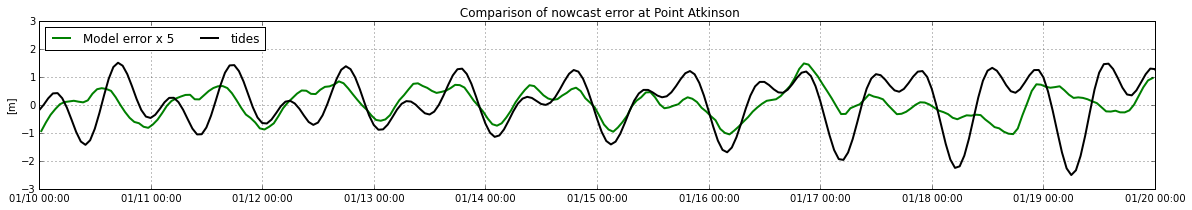

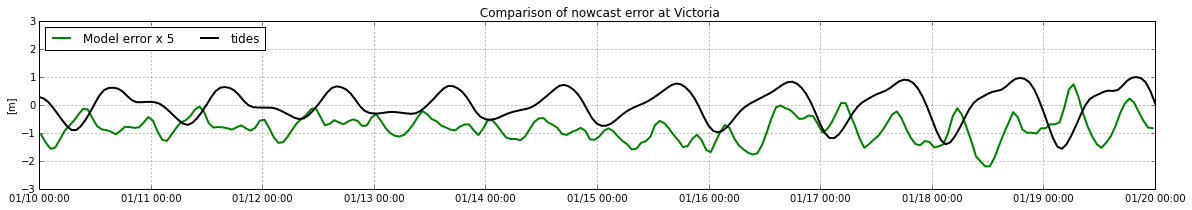

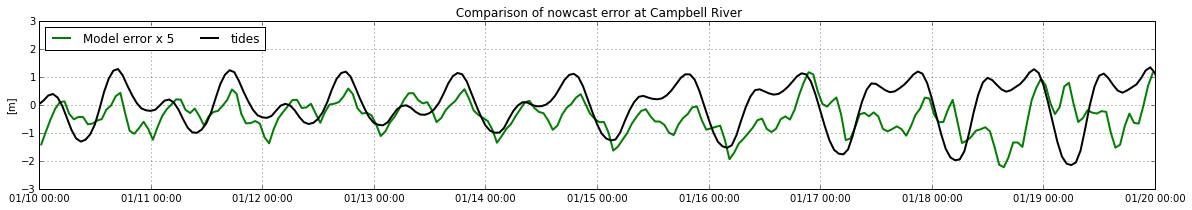

In [70]:
t_orig=datetime.datetime(2015,1,10)
t_final = datetime.datetime(2015,1,19)
mode = 'nowcast'
fig = compare_errors1('Point Atkinson', mode, t_orig,t_final,bathy)
fig = compare_errors1('Victoria', mode, t_orig,t_final,bathy)
fig = compare_errors1('Campbell River', mode, t_orig,t_final,bathy)

In [30]:
def compare_errors2(ax, name, mode, start, end, grid_B, cf, cm):
    """ compares the model and forcing error at a station between dates start and end
    for a simulation mode."""
    
    # array of dates for iteration
    numdays = (end-start).days
    dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()
    
    # intiialize figure and arrays
    e_frc=np.array([])
    t_frc=np.array([])
    e_mod=np.array([]) 
    t_mod=np.array([])
    # mean daily error
    frc_daily= np.array([])
    mod_daily = np.array([])
    t_daily = np.array([])
    
    ttide=figures.get_tides(name)
    
    for t_sim in dates:
        # check if the run happened
        if mode in verified_runs(t_sim):
            # retrieve forcing and model error
            e_frc_tmp, t_frc_tmp = calculate_error_forcing('Neah Bay', [mode], t_sim)
            e_mod_tmp, t_mod_tmp, _ = calculate_error_model([name], [mode], grid_B, t_sim)
            e_frc_tmp= figures.interp_to_model_time(t_mod_tmp[name][mode],e_frc_tmp['Neah Bay'][mode],t_frc_tmp['Neah Bay'][mode])
            # append to larger array
            e_frc = np.append(e_frc,e_frc_tmp)
            t_frc = np.append(t_frc,t_mod_tmp[name][mode])
            e_mod = np.append(e_mod,e_mod_tmp[name][mode])
            t_mod = np.append(t_mod,t_mod_tmp[name][mode])
            # append daily mean error
            frc_daily=np.append(frc_daily, np.mean(e_frc_tmp))
            mod_daily=np.append(mod_daily, np.mean(e_mod_tmp[name][mode]))
            t_daily=np.append(t_daily,t_sim+datetime.timedelta(hours=12))
        else: 
            print '{mode} simulation for {start} did not occur'.format(mode=mode, start=t_sim)
            
    # Plotting daily means 
    ax.plot(t_daily, frc_daily,  cf, label = 'Forcing, ' + mode, lw=2)
    ax.plot(t_daily, mod_daily, cm, lw=2, label = 'Model, ' + mode)
    ax.set_title(' Comparison of daily mean error at {name}'.format(mode=mode,name=name))
    ax.set_ylim([-.35,.35])
    
    # format axes
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(hfmt)
    ax.legend(loc=2, ncol=6)
    ax.grid()
    ax.set_xlim([start,end+datetime.timedelta(days=1)])
    ax.set_ylabel('[m]')
       
    return fig

forecast simulation for 2015-01-18 00:00:00 did not occur
forecast simulation for 2015-01-19 00:00:00 did not occur
forecast2 simulation for 2015-01-01 00:00:00 did not occur
forecast2 simulation for 2015-01-02 00:00:00 did not occur
forecast2 simulation for 2015-01-03 00:00:00 did not occur
forecast2 simulation for 2015-01-04 00:00:00 did not occur
forecast2 simulation for 2015-01-05 00:00:00 did not occur
forecast2 simulation for 2015-01-06 00:00:00 did not occur
forecast2 simulation for 2015-01-07 00:00:00 did not occur
forecast2 simulation for 2015-01-08 00:00:00 did not occur
forecast2 simulation for 2015-01-09 00:00:00 did not occur
forecast2 simulation for 2015-01-10 00:00:00 did not occur
forecast2 simulation for 2015-01-11 00:00:00 did not occur
forecast2 simulation for 2015-01-12 00:00:00 did not occur
forecast2 simulation for 2015-01-13 00:00:00 did not occur
forecast2 simulation for 2015-01-14 00:00:00 did not occur
forecast2 simulation for 2015-01-15 00:00:00 did not occur

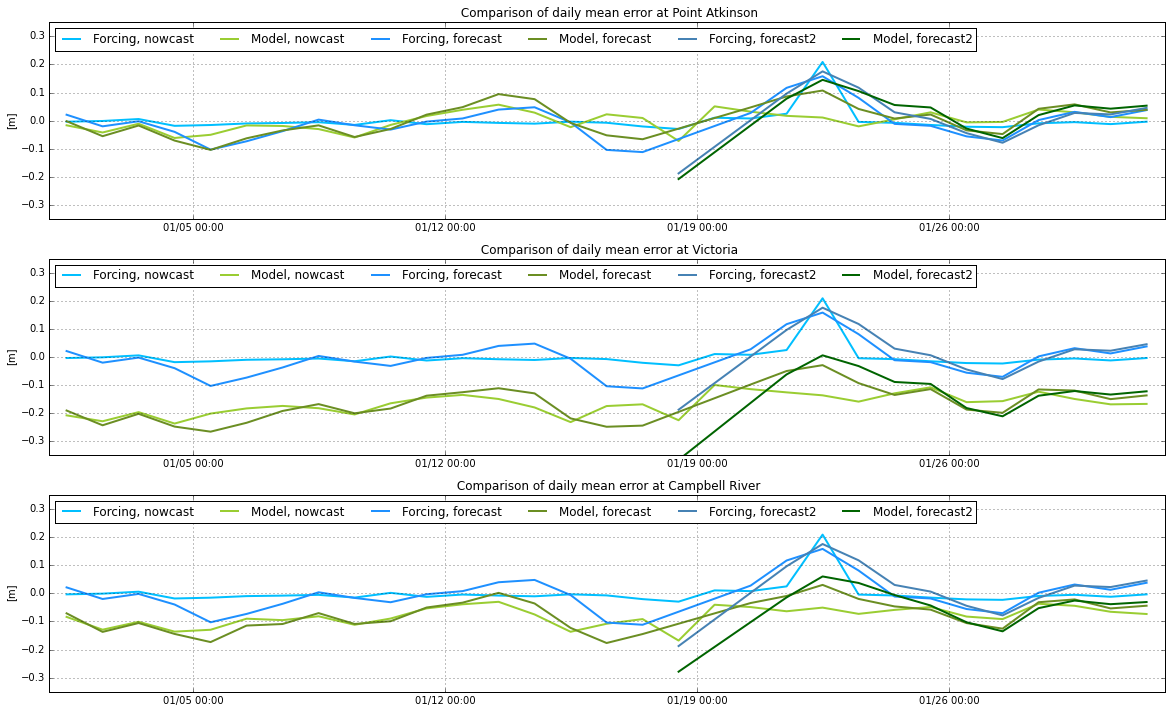

In [55]:
t_orig=datetime.datetime(2015,1,1)
t_final = datetime.datetime(2015,1,31)
fig,axs = plt.subplots(3,1,figsize=(20,12))
for name, n in zip (['Point Atkinson','Victoria','Campbell River'], np.arange(3)):
    fig = compare_errors2(axs[n], name, 'nowcast', t_orig,t_final,bathy,'DeepSkyBlue','YellowGreen')
    fig = compare_errors2(axs[n], name, 'forecast', t_orig,t_final,bathy,'DodgerBlue','OliveDrab')
    fig = compare_errors2(axs[n], name, 'forecast2', t_orig,t_final,bathy,'SteelBlue','DarkGreen')

In [31]:
def compare_errors3(name, mode, start, end, grid_B, figsize=(20,3)):
    """ compares the model and forcing error at a station between dates start and end
    for a simulation mode."""
    
    # array of dates for iteration
    numdays = (end-start).days
    dates = [start + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()
    
    fig,ax = plt.subplots(1,1,figsize=figsize)
    # intiialize figure and arrays
    e_frc=np.array([])
    t_frc=np.array([])
    e_mod=np.array([]) 
    t_mod=np.array([])
    # mean daily error
    frc_daily= np.array([])
    mod_daily = np.array([])
    t_daily = np.array([])
    
    ttide=figures.get_tides(name)
    
    for t_sim in dates:
        # check if the run happened
        if mode in verified_runs(t_sim):
            # retrieve forcing and model error
            e_frc_tmp, t_frc_tmp = calculate_error_forcing('Neah Bay', [mode], t_sim)
            e_mod_tmp, t_mod_tmp, _ = calculate_error_model([name], [mode], grid_B, t_sim)
            e_frc_tmp= figures.interp_to_model_time(t_mod_tmp[name][mode],e_frc_tmp['Neah Bay'][mode],t_frc_tmp['Neah Bay'][mode])
            # append to larger array
            e_frc = np.append(e_frc,e_frc_tmp)
            t_frc = np.append(t_frc,t_mod_tmp[name][mode])
            e_mod = np.append(e_mod,e_mod_tmp[name][mode])
            t_mod = np.append(t_mod,t_mod_tmp[name][mode])
            # append daily mean error
            frc_daily=np.append(frc_daily, np.mean(e_frc_tmp))
            mod_daily=np.append(mod_daily, np.mean(e_mod_tmp[name][mode]))
            t_daily=np.append(t_daily,t_sim+datetime.timedelta(hours=12))
            # stdev
            stdev_mod = (max(np.cumsum((mod_daily-np.mean(e_mod))**2))/len(mod_daily))**0.5
        else: 
            print '{mode} simulation for {start} did not occur'.format(mode=mode, start=t_sim)
            
    # Plotting daily means 
    ax.plot(t_daily, frc_daily,  'b', label = 'Forcing, ' + mode, lw=2)
    ax.plot(t_daily, mod_daily, 'g', lw=2, label = 'Model, ' + mode)
    #ax.plot([t_frc[0],t_frc[-1]],[np.mean(e_frc),np.mean(e_frc)], '--b', label='Mean forcing error', lw=2)
    #ax.plot([t_mod[0],t_mod[-1]],[np.mean(e_mod),np.mean(e_mod)], '--g', label='Mean model error', lw=2)
    ax.set_title(' Comparison of daily mean error at {name}'.format(mode=mode,name=name))
    ax.set_ylim([-.35,.35])
    
    # format axes
    hfmt = mdates.DateFormatter('%m/%d %H:%M')
    ax.xaxis.set_major_formatter(hfmt)
    ax.legend(loc=2, ncol=6)
    ax.grid()
    ax.set_xlim([start,end+datetime.timedelta(days=1)])
    ax.set_ylabel('[m]')
    print stdev_mod
    
    return fig

0.0125982966754
0.0435648311803
0.0388926269505


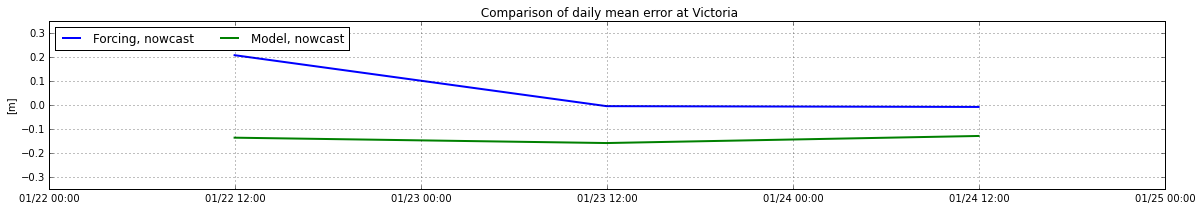

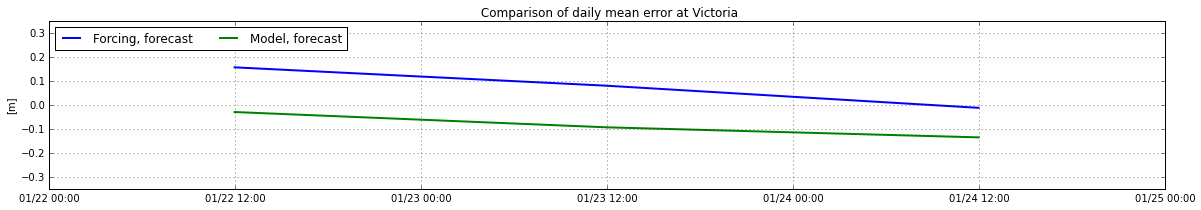

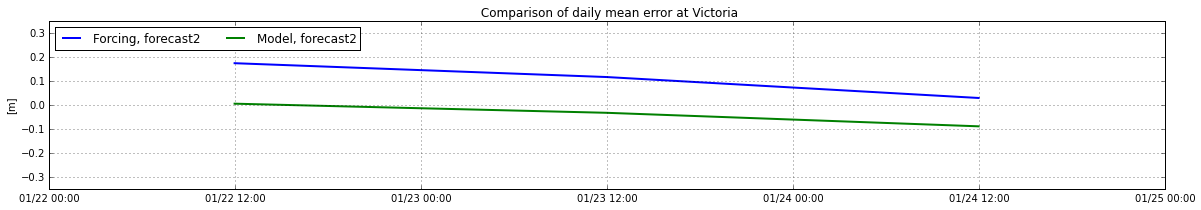

In [33]:
t_orig=datetime.datetime(2015,1,22)
t_final = datetime.datetime(2015,1,24)
fig = compare_errors3('Victoria', 'nowcast', t_orig,t_final,bathy)
fig = compare_errors3('Victoria', 'forecast', t_orig,t_final,bathy)
fig = compare_errors3('Victoria', 'forecast2', t_orig,t_final,bathy)